# Import

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)

PROJECT_DIR = os.path.join(os.path.dirname('bert_modeling.ipynb'), os.pardir) + '/..'

In [2]:
# Google Colab setup
from google.colab import drive, userdata
drive.mount('/content/drive/')
PROJECT_DIR = userdata.get('PROJECT_DIR')

Mounted at /content/drive/


In [3]:
# Reading the up-sampled dataset
up_train = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_train.csv', usecols=['Description', 'Accident Level'])
test = pd.read_csv(f'{PROJECT_DIR}/data/processed/augmented_test.csv', usecols=['Description', 'Accident Level'])
up_train.head()

,Description,Accident Level
0,By manually moving a steel cabinet for disposa...,3
1,Once the mooring of the faneles in the detonat...,1
2,When performing cleaning activity of the area ...,3
3,The technician was doing the magnetometric sur...,1
4,The operator cleaned with spatula spear throug...,1


In [4]:
# Splitting features and targets
x_train = up_train['Description'].str.strip()
y_train = up_train['Accident Level']

x_test = test['Description'].str.strip()
y_test = test['Accident Level']

In [5]:
# Label encoding to ensure the labels start from 0
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [6]:
# One-hot encoding
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

In [7]:
# Tensor slicing
from tensorflow.data import Dataset

train_ds = Dataset.from_tensor_slices((x_train, y_train_ohe))
test_ds = Dataset.from_tensor_slices((x_test, y_test_ohe))

# BERT

## Installations

In [8]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.15.*"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 40.9 MB/s eta 0:00:00


In [9]:
# To define AdamW Optimizer
!pip install "tf-models-official==2.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=38b9b9fd0f865915f0ce6c8ea40297909e9754476d61e7dc1e6238d07f89b3fb
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [1]:
from tensorflow import string
import tensorflow_text as text
from tensorflow_hub import KerasLayer
from tensorflow.keras import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.layers import Input, Dropout, Dense, Bidirectional, LSTM, Embedding, GlobalMaxPooling1D

ImportError: cannot import name 'AdamW' from 'tensorflow.keras.optimizers' (c:\Users\suhai\anaconda3\envs\gpu\lib\site-packages\keras\api\_v2\keras\optimizers\__init__.py)

In [16]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

def build_bert_lstm():
    text_input = Input(shape=(), dtype=string, name='text_input')
    bert_preprocessing = KerasLayer(tfhub_handle_preprocess, name='bert_preprocessing')(text_input)
    bert_encoder = KerasLayer(tfhub_handle_encoder, trainable=False, name='bert_encoder')(bert_preprocessing)

    lstm_1 = Bidirectional(LSTM(512, return_sequences=True))(bert_encoder['sequence_output'])
    lstm_2 = Bidirectional(LSTM(256, return_sequences=True))(lstm_1)
    max_pool = GlobalMaxPooling1D()(lstm_2)

    dropout_1 = Dropout(0.2)(max_pool)
    dense_1 = Dense(128, activation='relu')(dropout_1)

    dropout_2 = Dropout(0.2)(dense_1)
    dense_2 = Dense(64, activation='relu')(dropout_2)

    dropout_3 = Dropout(0.2)(dense_2)
    dense_3 = Dense(32, activation='relu')(dropout_3)

    dropout_4 = Dropout(0.2)(dense_3)
    classifier = Dense(5, activation='softmax', name='classifier')(dropout_4)

    model = Model(text_input, classifier)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=AdamW(learning_rate=3e-5, weight_decay=0.001, epsilon=1e-07),
        metrics=['accuracy', Recall(), Precision()]
    )

    return model

In [17]:
bert_lstm = build_bert_lstm()
bert_lstm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 bert_preprocessing (KerasL  {'input_word_ids': (None,    0         ['text_input[0][0]']          
 ayer)                       128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_delta=1e-6, verbose=1),
    ModelCheckpoint(PROJECT_DIR + '/models/bert_lstm_copy2/bert_lstm_tf', monitor='val_loss', save_best_only=True, initial_value_threshold=1, verbose=1)
]

In [19]:
history = bert_lstm.fit(train_ds.batch(32), validation_data=test_ds.batch(32), epochs=100, callbacks=callbacks)

Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 1.5778 - accuracy: 0.2442 - recall: 0.0190 - precision: 0.3793
Epoch 1: val_loss did not improve from 1.00000
37/37 [==============================] - 91s 1s/step - loss: 1.5778 - accuracy: 0.2442 - recall: 0.0190 - precision: 0.3793 - val_loss: 1.6954 - val_accuracy: 0.0190 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 3.0000e-05
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 1.5179 - accuracy: 0.2736 - recall: 8.6580e-04 - precision: 0.1000
Epoch 2: val_loss did not improve from 1.00000
37/37 [==============================] - 35s 957ms/step - loss: 1.5179 - accuracy: 0.2736 - recall: 8.6580e-04 - precision: 0.1000 - val_loss: 1.6405 - val_accuracy: 0.0667 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 3.0000e-05
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 1.3708 - accuracy: 0.3870 - recall: 0.0485 - precision: 0.3784
Epoch 3: val_loss did not i

KeyboardInterrupt: 

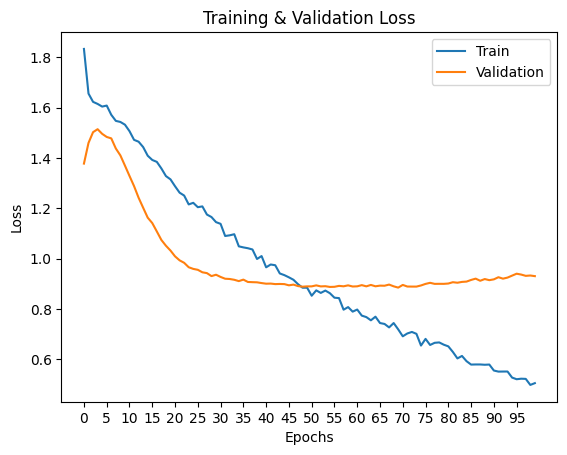

In [ ]:
# Loss plot
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0, 100, 5))
plt.legend()
plt.show();

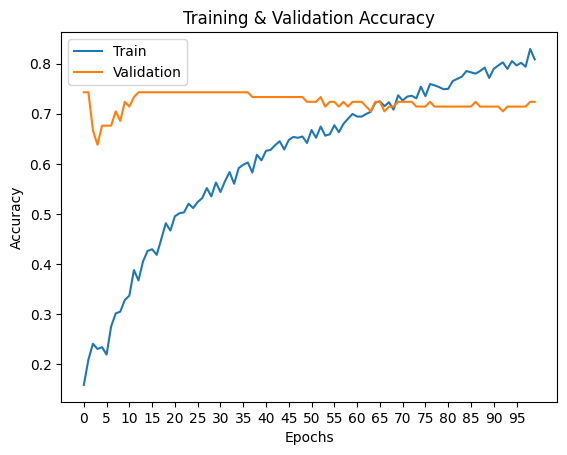

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0, 100, 5))
plt.legend()
plt.show();

In [ ]:
print('Training Performance:')
train_results = bert_lstm.evaluate(train_ds)
print('loss', train_results[0])
print('accuracy', train_results[1])
print('recall', train_results[2])
print('precision', train_results[3])

Training Performance:
1155/1155 [==============================] - 29s 23ms/step - loss: 0.2935 - accuracy: 0.9030 - recall_3: 0.8935 - precision_3: 0.9314
loss 0.2934702932834625
accuracy 0.903030276298523
recall 0.8935064673423767
precision 0.9314079284667969


In [ ]:
print('Testing Performance:')
train_results = bert_lstm.evaluate(test_ds)
print('loss', train_results[0])
print('accuracy', train_results[1])
print('recall', train_results[2])
print('precision', train_results[3])

Testing Performance:
105/105 [==============================] - 3s 27ms/step - loss: 0.9302 - accuracy: 0.7238 - recall_3: 0.6857 - precision_3: 0.7579
loss 0.9301599860191345
accuracy 0.723809540271759
recall 0.6857143044471741
precision 0.75789475440979


In [ ]:
bert_lstm.save(f'{PROJECT_DIR}/models/bert_lstm_copy2/bert_lstm_model.h5')

In [ ]:
bert_lstm.save_weights(f'{PROJECT_DIR}/models/bert_lstm_copy2/bert_lstm_model_weights.h5')

In [ ]:
bert_lstm.save(f'{PROJECT_DIR}/models/bert_lstm_copy2/bert_lstm_model', save_format='tf')

In [ ]:
bert_lstm.save(f'{PROJECT_DIR}/models/bert_lstm_copy2/bert_lstm_model.keras')

In [ ]:
bert_lstm = build_bert_lstm()
bert_lstm.load_weights(f'{PROJECT_DIR}/models/bert_lstm_copy2/bert_lstm_model_weights.h5')

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(build_bert_lstm(), to_file=f'{PROJECT_DIR}bert_lstm.png', show_shapes=True, show_layer_names=True)